In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
%matplotlib inline

MessageError: ignored

# Feature Selection

In [ ]:
#Entire data set
X_train_all = pd.read_csv('/content/drive/MyDrive/C170MPresentationJioSandraTina/X_train.csv', header=None)
y_train = pd.read_csv('/content/drive/MyDrive/C170MPresentationJioSandraTina/y_train.csv', header=None)
X_test_all = pd.read_csv('/content/drive/MyDrive/C170MPresentationJioSandraTina/X_test.csv', header=None)
y_test = pd.read_csv('/content/drive/MyDrive/C170MPresentationJioSandraTina/y_test.csv', header=None)
X_valid_all = pd.read_csv('/content/drive/MyDrive/C170MPresentationJioSandraTina/X_valid.csv', header=None)
y_valid = pd.read_csv('/content/drive/MyDrive/C170MPresentationJioSandraTina/y_valid.csv', header=None)
print(X_train_all.shape, y_train.shape, X_test_all.shape, y_test.shape, X_valid_all.shape, y_valid.shape)

(7352, 561) (7352, 1) (1597, 561) (1597, 1) (1350, 561) (1350, 1)


In [ ]:
#accuracy score for all features
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train_all,np.ravel(y_train))
y_pred = clf.predict(X_test_all)
score = accuracy_score(y_test,y_pred)
print(score)

0.9142141515341264


In [ ]:
#Array of indices of features we are not using
features_to_delete = np.concatenate([range(6, 9), range(19, 22), range(46, 49), range(59, 62), range(86, 89), range(99, 102), range(126, 129), range(139, 142), range(166, 169), range(179, 182), range(200, 265), range(268, 277), range(290, 293), range(296, 302), range(347, 356), range(369, 372), range(375, 381), range(426, 435), range(448, 451), range(454, 460), range(502, 554)])
print(features_to_delete)
print(features_to_delete.shape)

[  6   7   8  19  20  21  46  47  48  59  60  61  86  87  88  99 100 101
 126 127 128 139 140 141 166 167 168 179 180 181 200 201 202 203 204 205
 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223
 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241
 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259
 260 261 262 263 264 268 269 270 271 272 273 274 275 276 290 291 292 296
 297 298 299 300 301 347 348 349 350 351 352 353 354 355 369 370 371 375
 376 377 378 379 380 426 427 428 429 430 431 432 433 434 448 449 450 454
 455 456 457 458 459 502 503 504 505 506 507 508 509 510 511 512 513 514
 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532
 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550
 551 552 553]
(201,)


These features are decided by prior knowledge and noticing correlations between features.

In [ ]:
#Array of indices of features we ARE using
full_arr = np.arange(0, 561)
features_to_keep = np.setdiff1d(full_arr, features_to_delete)

In [ ]:
#Trimmed data
X_train = X_train_all.drop(X_train_all.columns[features_to_delete], axis=1)
X_test = X_test_all.drop(X_test_all.columns[features_to_delete], axis=1)
X_valid = X_valid_all.drop(X_valid_all.columns[features_to_delete], axis=1)

Now, we have 360 features left, and we want to further trim it down.
First, we looked at the feature importances from the random forest model to get a sense of how feature importances are distributed among the 360 features.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(min_samples_split=10)
#min_samples_split is set to 10 because we want to avoid potential bias in feature importance due to high cardinality data
y_train_arr = np.ravel(y_train)
clf.fit(X_train,y_train_arr)

RandomForestClassifier(min_samples_split=10)

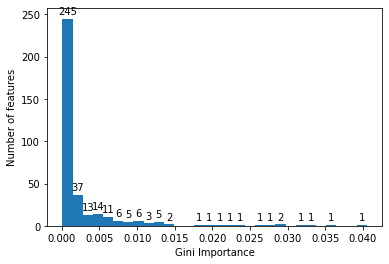

In [ ]:
importances = clf.feature_importances_
counts, bins, patches = plt.hist(importances,bins=30)
for count, patch in zip(counts, patches):
    if count > 0:
        plt.text(patch.get_x()+patch.get_width()/2, patch.get_height()+5, str(int(count)), ha='center')
plt.ylabel('Number of features')
plt.xlabel('Gini Importance')
plt.show()

Among 360 features, about 100 features have the top order of magnitude of feature importance, so we will look at the top 100 features from now on.

In [ ]:
Top100 = []
for i in range(40):
    clf = RandomForestClassifier(min_samples_split=10)
    clf.fit(X_train,y_train_arr)
    importances = clf.feature_importances_
    ind = np.argpartition(importances,-100)[-100:]
    Top100 = np.concatenate((Top100,ind))

In [ ]:
values, counts = np.unique(Top100, return_counts=True)
index = np.argsort(-counts)
values = values[index]
index_100 = values[:100]
sorted_index_100 = sorted(index_100)
features1 = []
for i in range(100):
  features1.append(features_to_keep[int(sorted_index_100[i])])

The 100 features with the highest feature importance vary slightly with each run of random forest, so we ran random forest 40 times, each time we found the 100 features with the highest feature importance and saved them to the 'Top100' array. Then, we chose the 100 features that appeared most of the times in the Top100 array and saved them in the 'features1' array.

Since the feature importance method has its limitations, we also tried permutation importance. We found the 100 features with the highest permutation importance in random forest, and saved them in 'features2' array.

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train,np.ravel(y_train))
result = permutation_importance(clf, X_test, y_test, scoring='accuracy',n_repeats=5, random_state=42)
ind = []
ind = np.argpartition(result.importances_mean,-100)[-100:]

In [ ]:
sorted_ind = sorted(ind)
features2 = []
for i in range(100):
  features2.append(features_to_keep[sorted_ind[i]])

Now, we found the intersection between 'features1' and 'features2' and saved them in 'features_final'.

In [ ]:
features_final = np.intersect1d(features1, features2)
features_final.size

49

features_final: [  9,  16,  22,  37,  38,  43,  44,  52,  54,  62,  63,  65,  66, 68,  73,  74,  75,  76,  83,  84,  89,  96, 102, 123, 129, 132, 136, 142, 159, 295, 302, 310, 314, 344, 359, 360, 381, 382, 383, 395, 403, 409, 439, 445, 451, 460, 468, 472, 560]

In [ ]:
X_train_new = X_train[features_final]
X_test_new = X_test[features_final]
X_valid_new = X_valid[features_final]

In [ ]:
#Testing this final array of features
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train_new,np.ravel(y_train))
y_pred = clf.predict(X_test_new)
score= accuracy_score(y_test,y_pred)
print(score)
print(classification_report(y_test,y_pred))

0.9323731997495304
              precision    recall  f1-score   support

           1       0.89      0.99      0.94       278
           2       0.89      0.90      0.90       257
           3       0.95      0.81      0.88       231
           4       0.94      0.91      0.93       258
           5       0.93      0.95      0.94       288
           6       1.00      1.00      1.00       285

    accuracy                           0.93      1597
   macro avg       0.93      0.93      0.93      1597
weighted avg       0.93      0.93      0.93      1597



The features in 'features_final' array give a high accuracy score, so they are good features.

In [ ]:
#plotting some of the important features
feature_names = [str(i) for i in range(561)]
y_train.columns=['labels']
X_train_all.columns=feature_names
data = pd.concat([X_train_all,y_train],axis = 1)

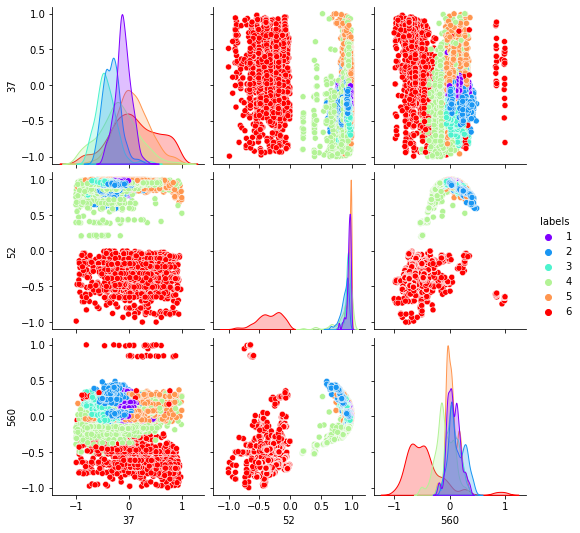

In [ ]:
sns.pairplot(data[["37","52",'560','labels']],hue='labels',palette='rainbow')